In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

데이터 사전 처리(preprocessing)

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./dataset/house_price.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
print(house_df.shape,'\n') #1461행 81열
print(house_df.dtypes.value_counts(),'\n')
isnull_series=house_df.isnull().sum()
print(isnull_series[isnull_series>0].sort_values(ascending=False))

(1460, 81) 

object     43
int64      35
float64     3
dtype: int64 

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


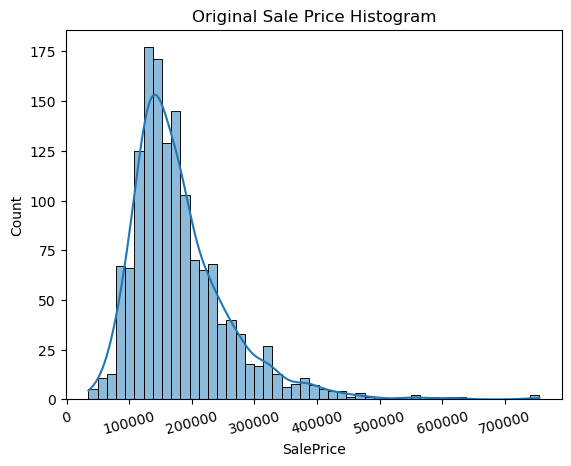

In [12]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15) #글자 각도
sns.histplot(house_df['SalePrice'],kde=True)
plt.show()

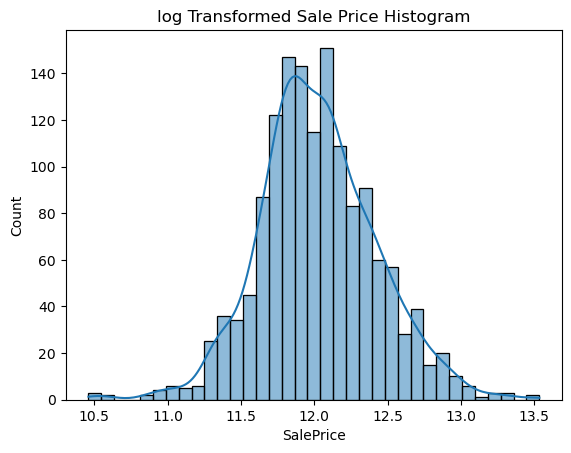

In [13]:
# log1p 사용해서 로그변환 후 histplot 그리기
plt.title('log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [14]:
# 불필요한 컬럼 및 null 값 많은 칼럼 삭제

original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id', 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)
house_df.fillna(house_df.mean(), inplace=True)

In [15]:
# null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print(house_df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [16]:
print(house_df.shape)

(1460, 75)


In [17]:
house_df_ohe = pd.get_dummies(house_df)
print(house_df_ohe.shape)

(1460, 271)


In [18]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print(house_df.dtypes[null_column_count.index])

Series([], dtype: object)


In [19]:
house_df['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

#### 선형 회귀 모델의 학습/예측/평가

In [20]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154352, 0.12750846334053045, 0.17628250556471395]

In [22]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef

MSSubClass              -0.000488
LotFrontage              0.000390
LotArea                  0.000002
OverallQual              0.041866
OverallCond              0.032077
                           ...   
SaleCondition_AdjLand   -0.076029
SaleCondition_Alloca     0.028081
SaleCondition_Family    -0.063272
SaleCondition_Normal    -0.000464
SaleCondition_Partial    0.167346
Length: 270, dtype: float64

In [23]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

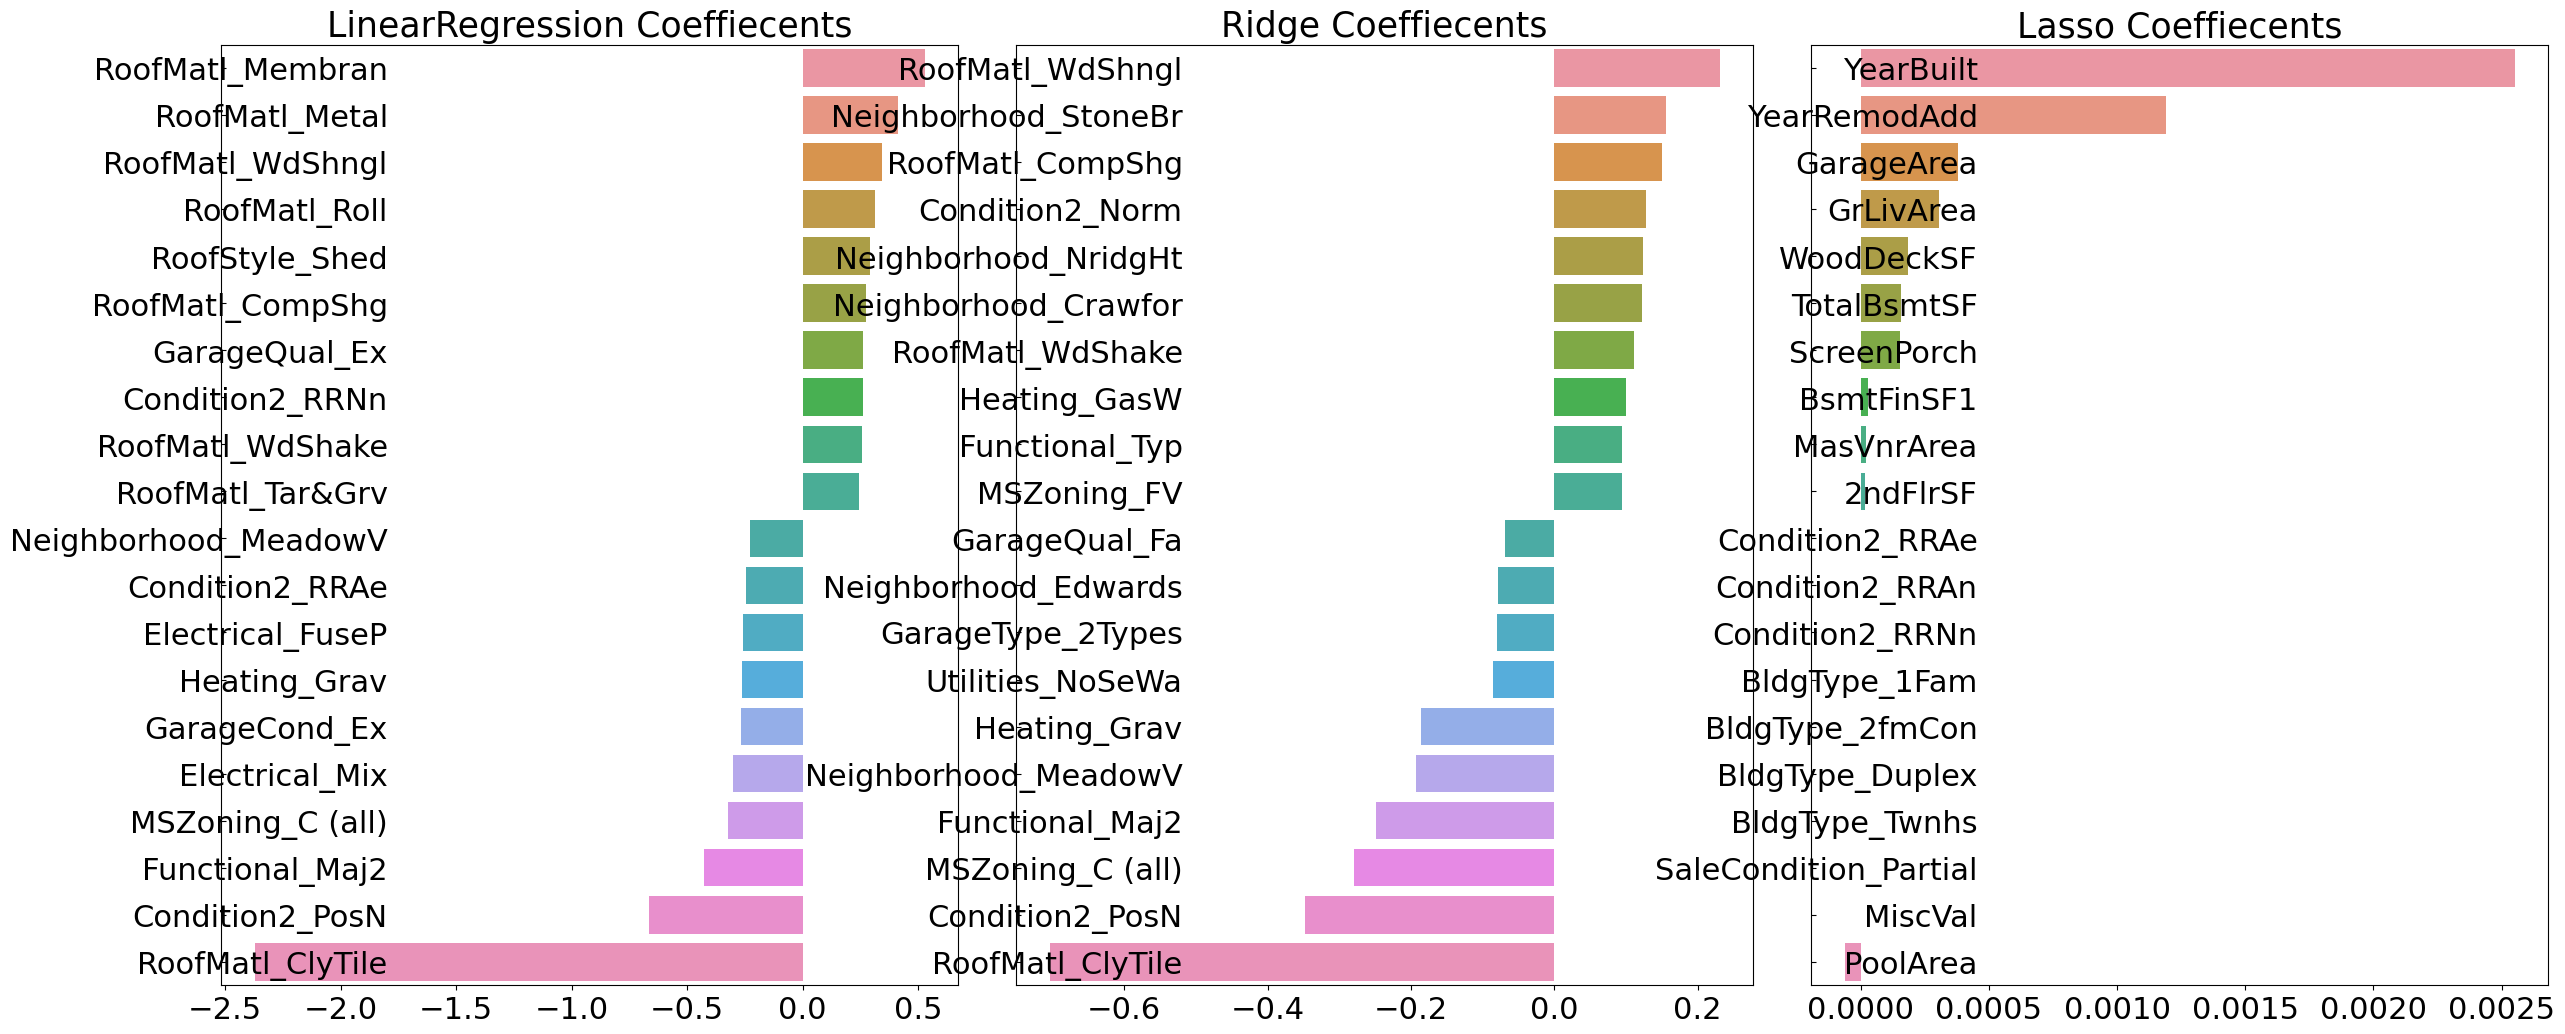

In [24]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) #위치 값 잡아주기
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [25]:
# 교차검증
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error',cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__,np.round(rmse_list,3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__,np.round(rmse_avg,3)))
        
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [26]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring = "neg_mean_squared_error", cv = 5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print("{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}".format(model.__class__.__name__,
                                                                np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = {"alpha" : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {"alpha" : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


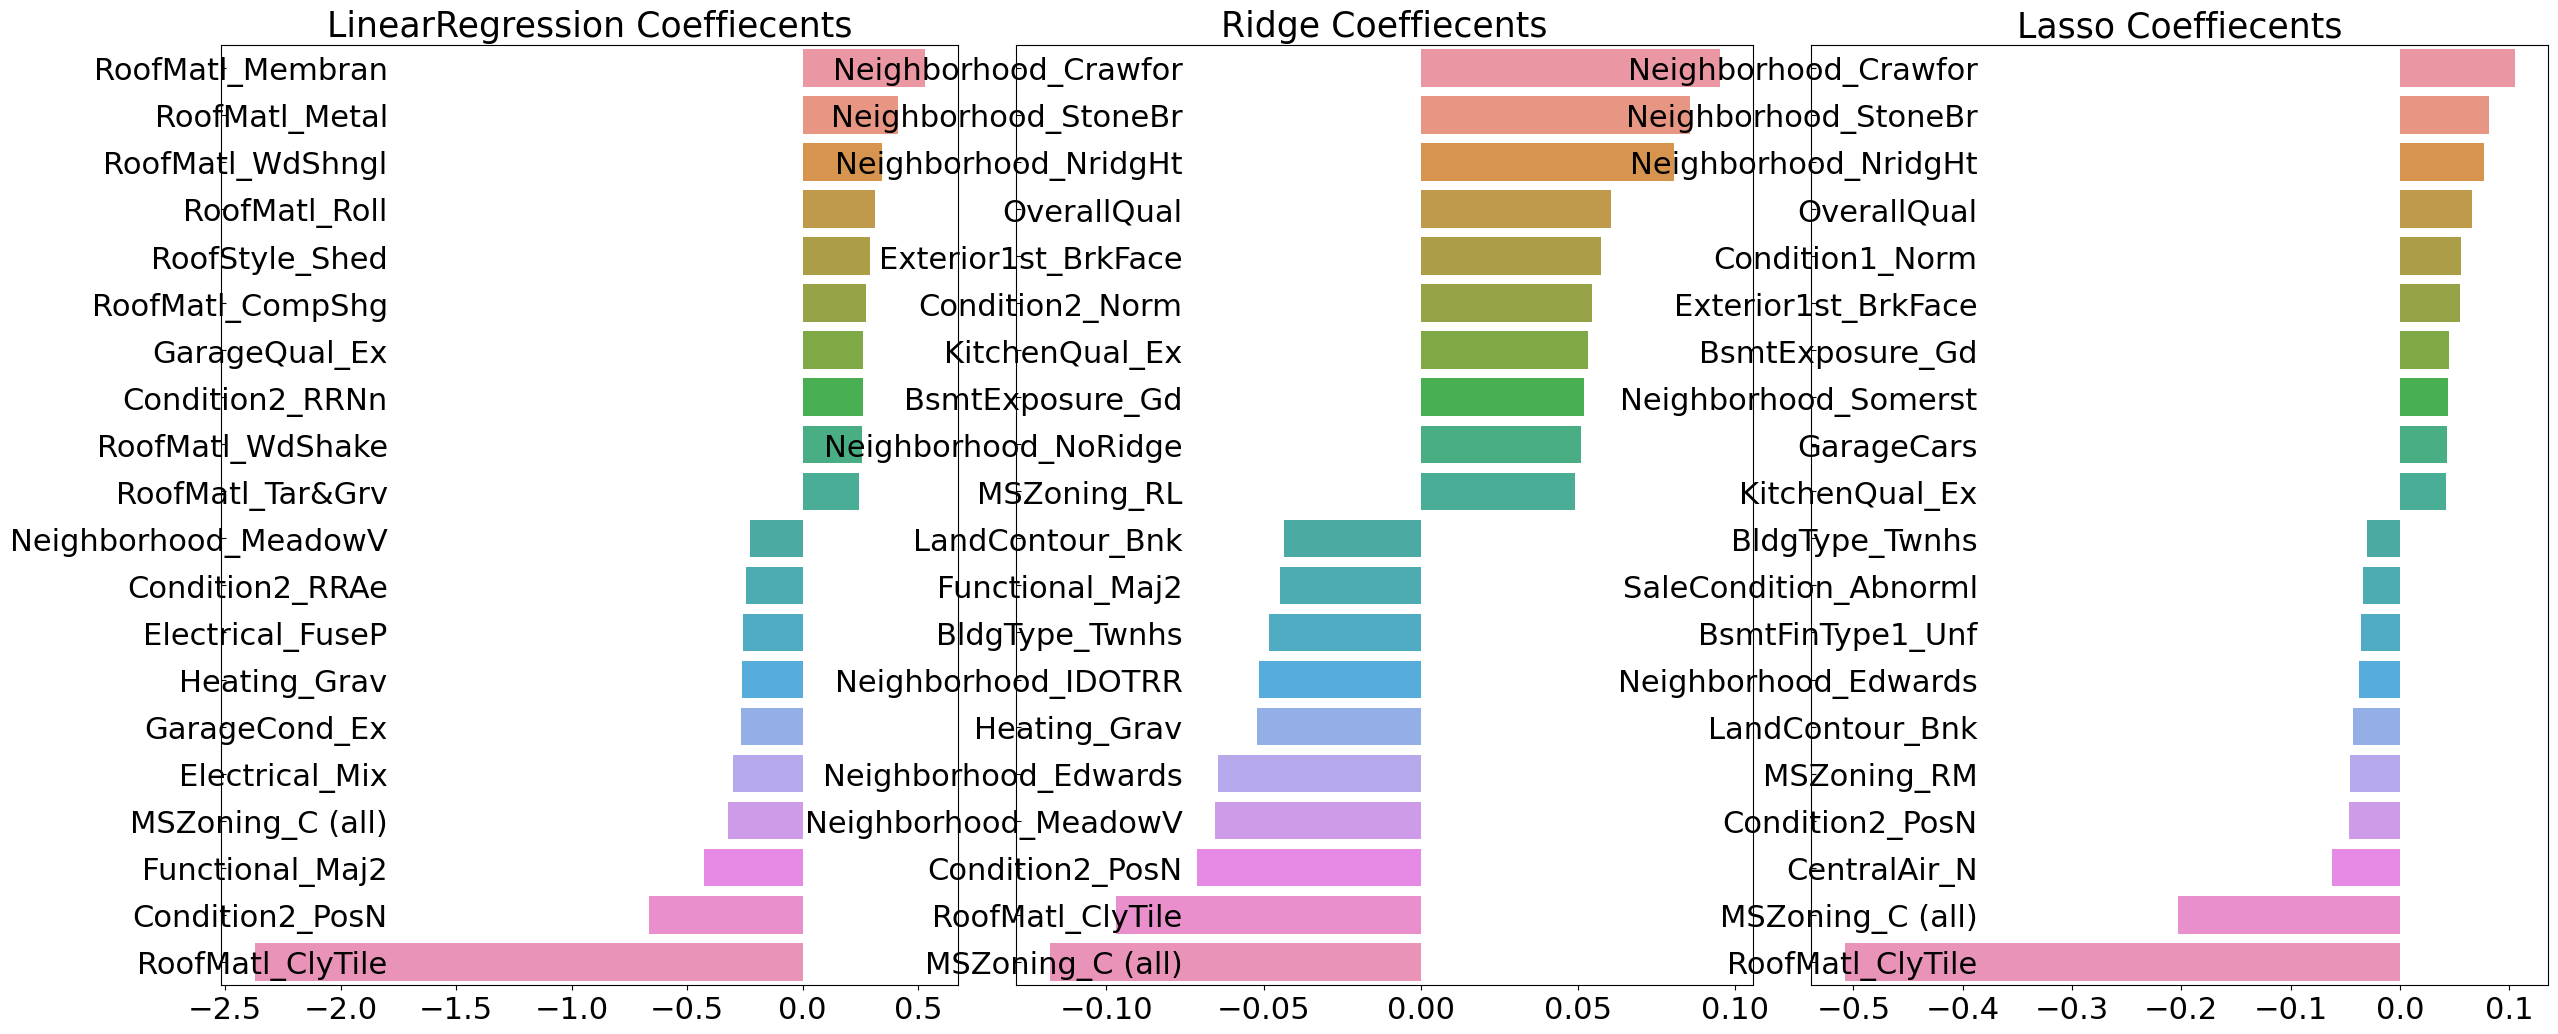

In [27]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

#### 데이터 왜곡 로그 변환 후 성능 평가

In [28]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes!='object'].index

skew_features = house_df[features_index].apply(lambda x : skew(x))

skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [8]:
# #original_SalePrice = house_df['SalePrice']
# house_df['MiscVal'] = np.log1p(house_df['MiscVal'])
# plt.title('log Transformed MiscVal Histogram')
# #log_SalePrice = np.log1p(house_df['MiscVal'])
# sns.histplot(house_df['MiscVal'], kde=True)
# plt.show()

In [30]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [31]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016
2,4.110874,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171
3,4.262680,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,5.609472,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405
4,4.110874,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220


In [32]:
house_df_ohe=pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {"alpha" : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {"alpha" : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


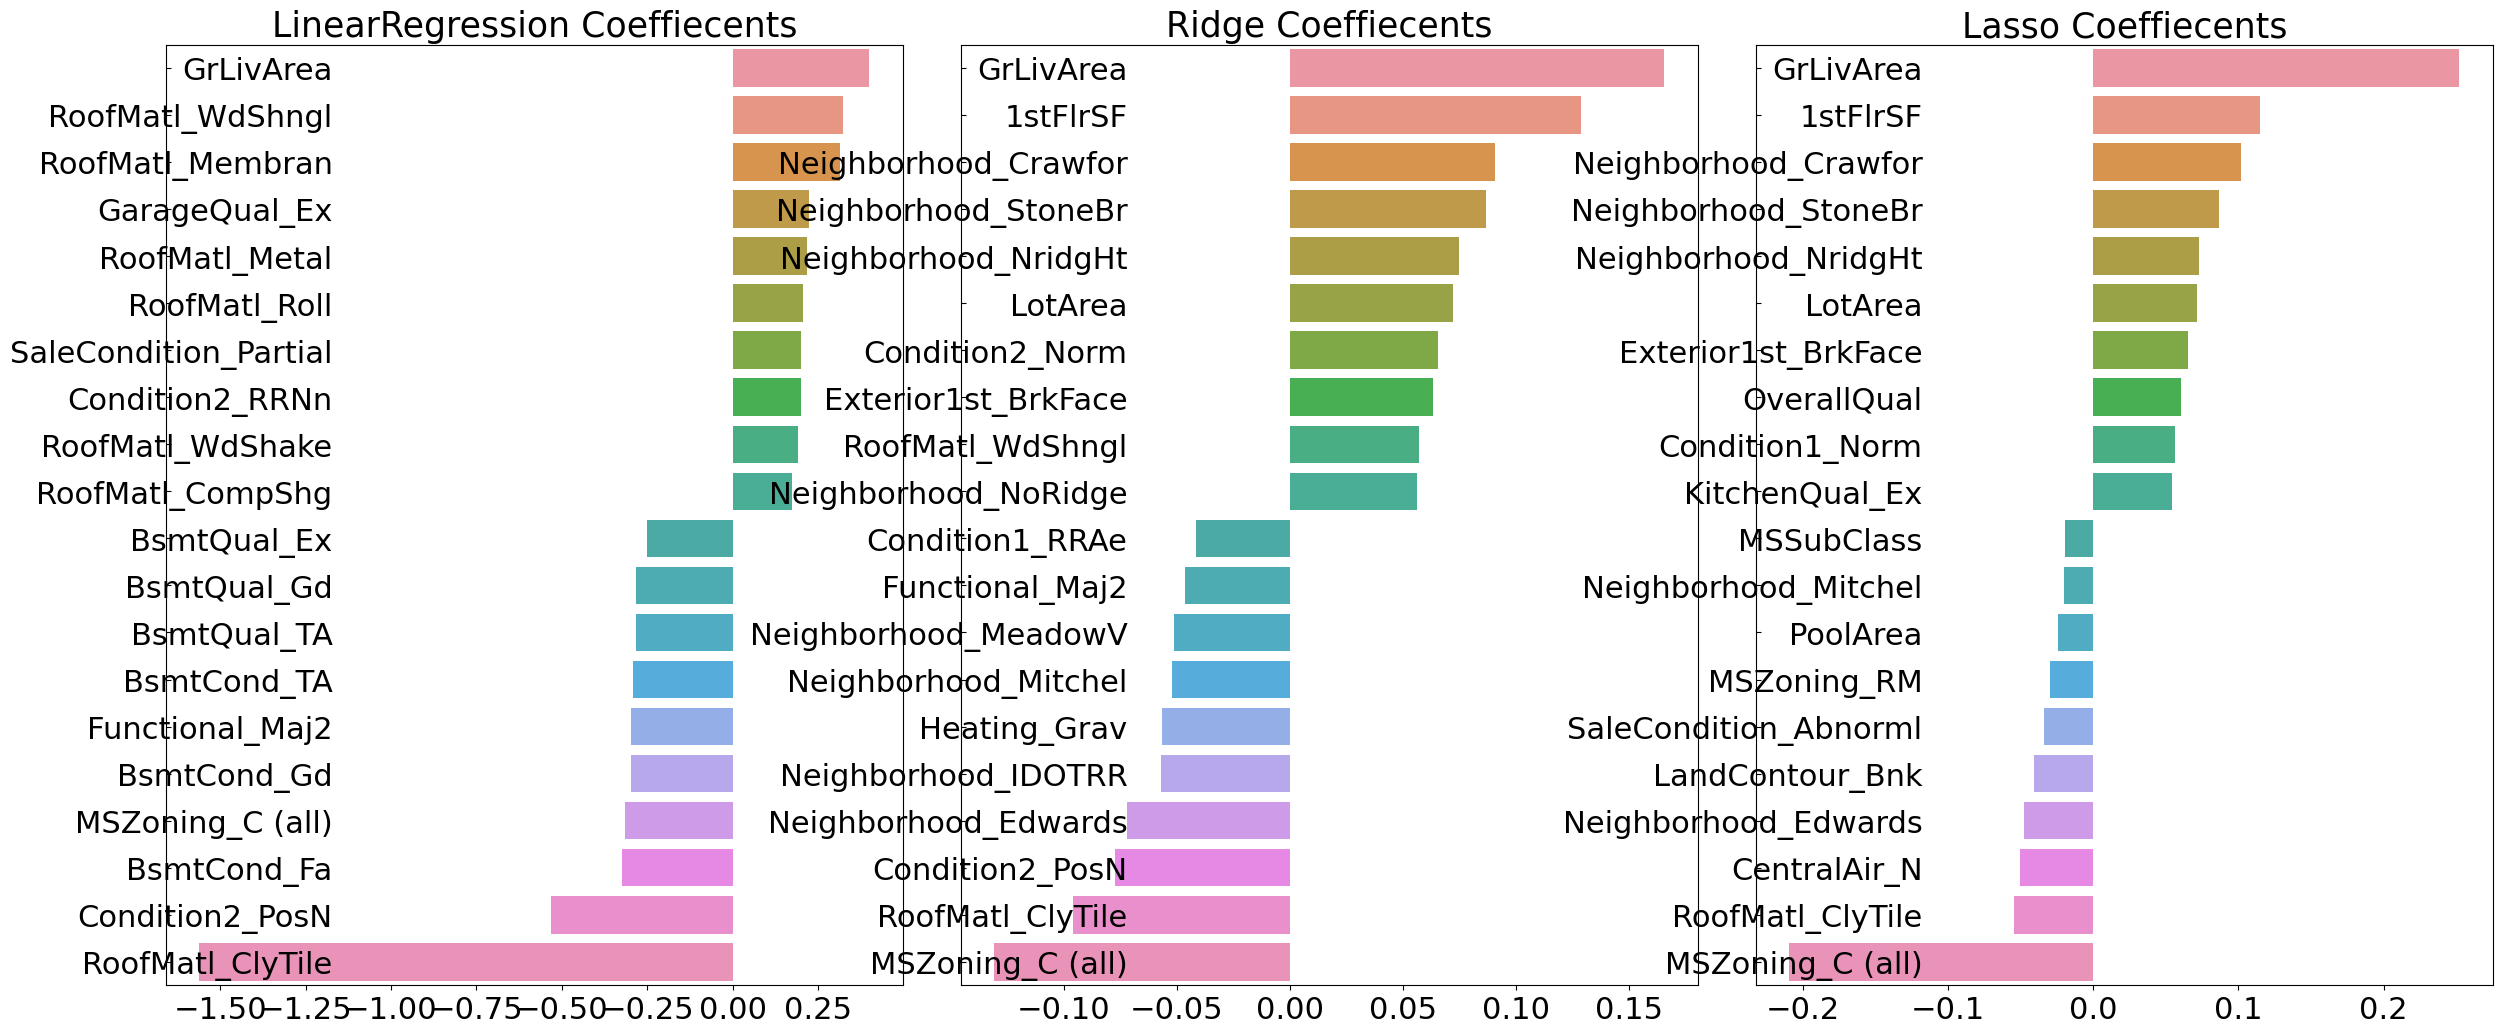

In [34]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

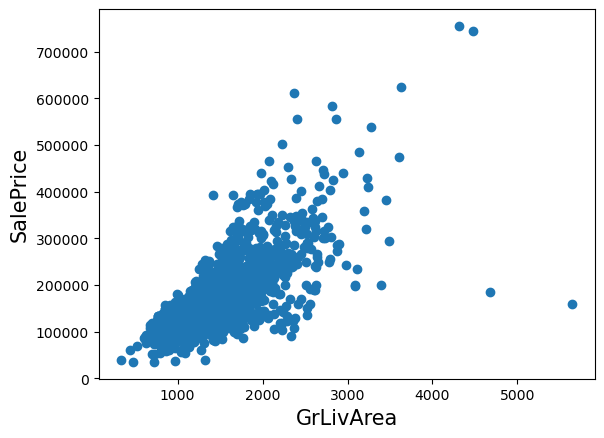

In [35]:
# 이상치 제거
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

In [36]:
cond1 = house_df_ohe['GrLivArea']>np.log1p(4000)
cond2 = house_df_ohe['SalePrice']>np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [ 691 1182]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [37]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {"alpha" : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {"alpha" : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1272, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1249, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.119
Ridge 로그 변환된 RMSE: 0.107
Lasso 로그 변환된 RMSE: 0.101


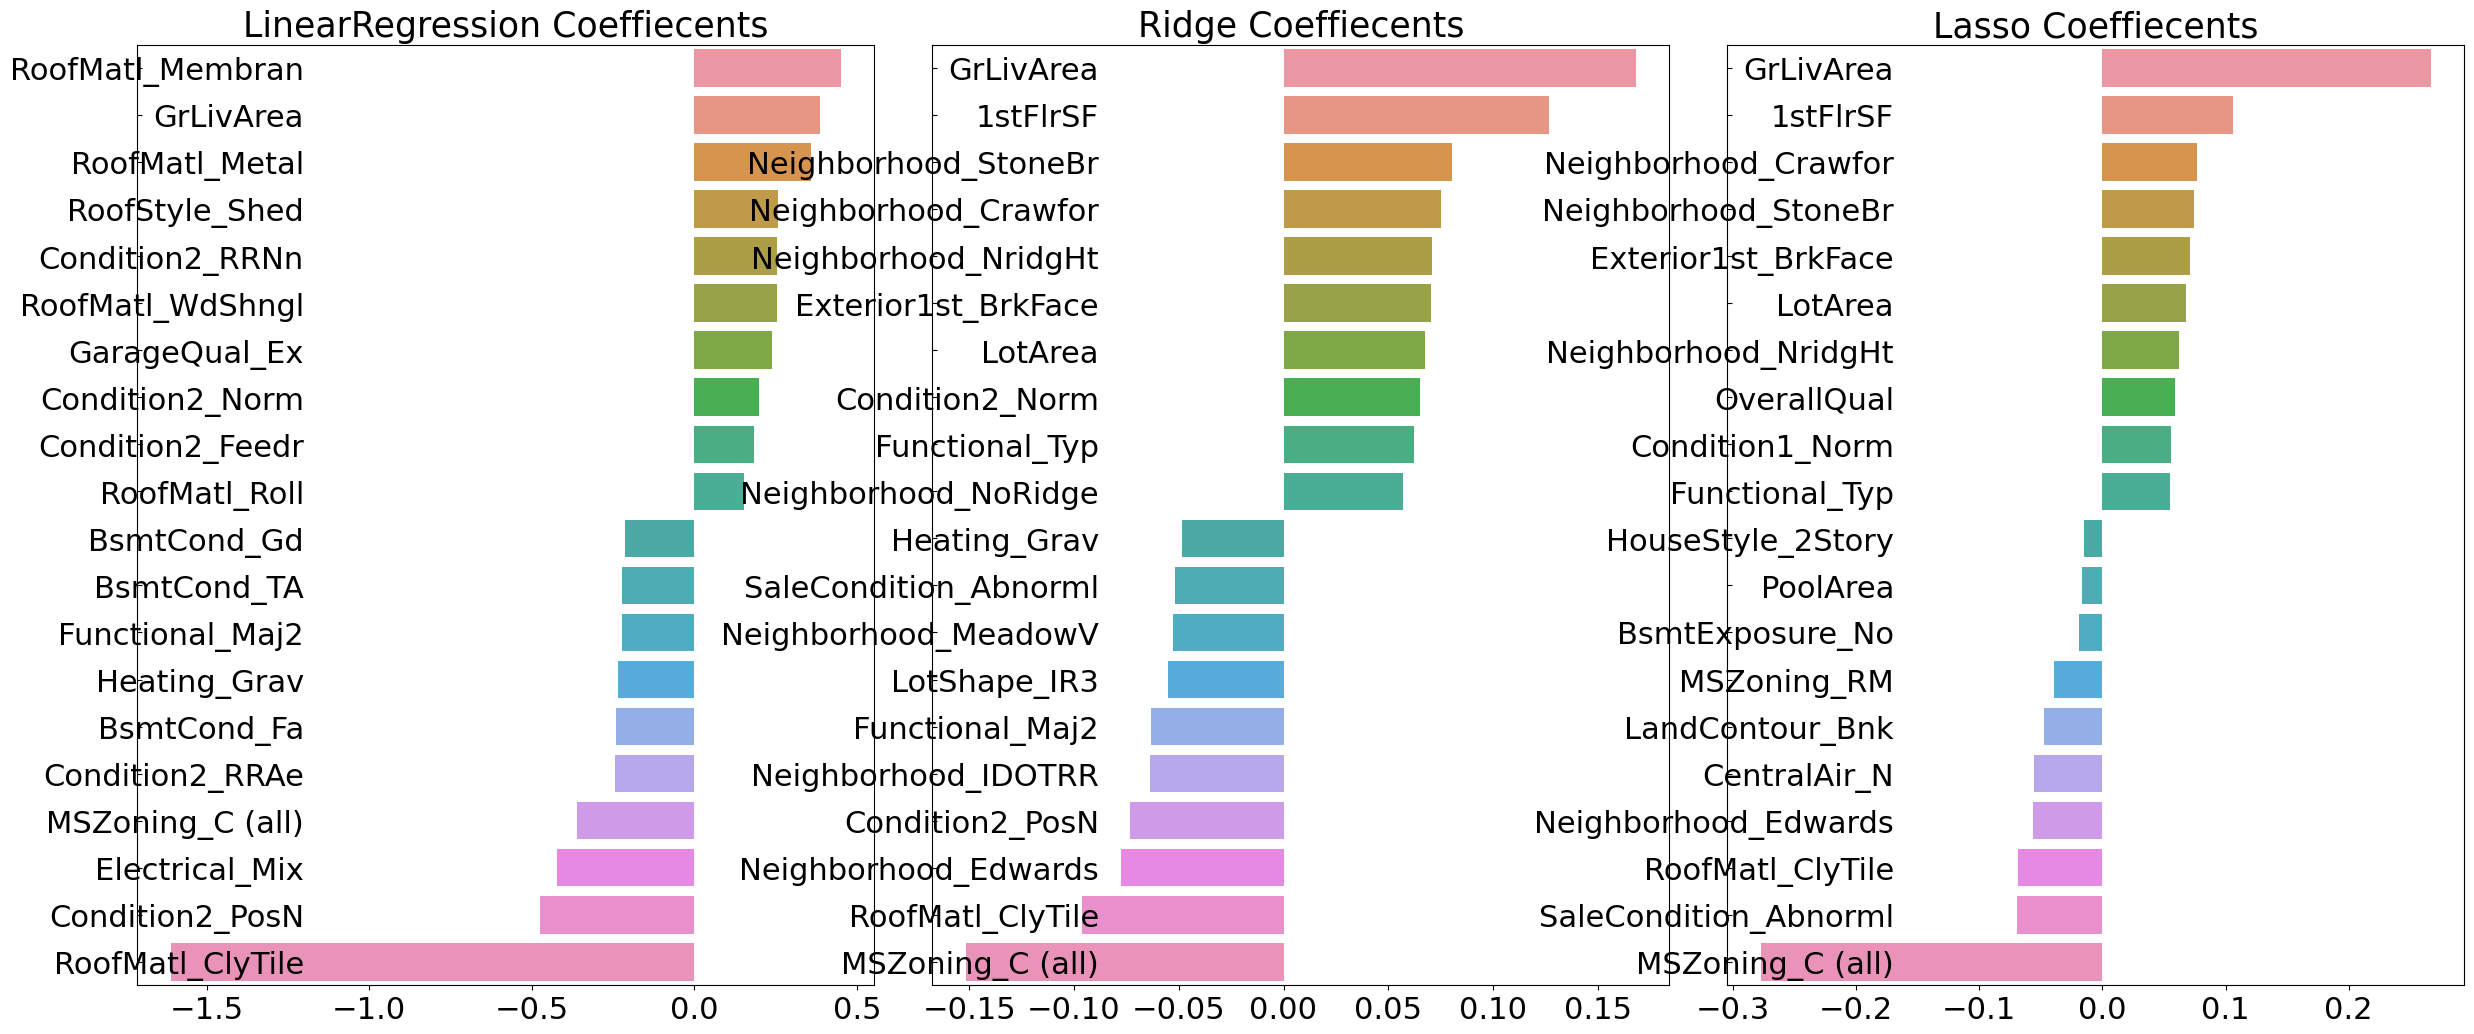

In [38]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

# lasso 에서 순위가 다르네.흠

#### 회귀트리 학습/예측/평가

In [39]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1228, 최적 alpha : {'n_estimators': 1000}


In [41]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, reg_lambda = 10, n_jobs=-1,
                         colsample_bytree=0.5, subsample=0.8)

best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1214, 최적 alpha : {'n_estimators': 1000}


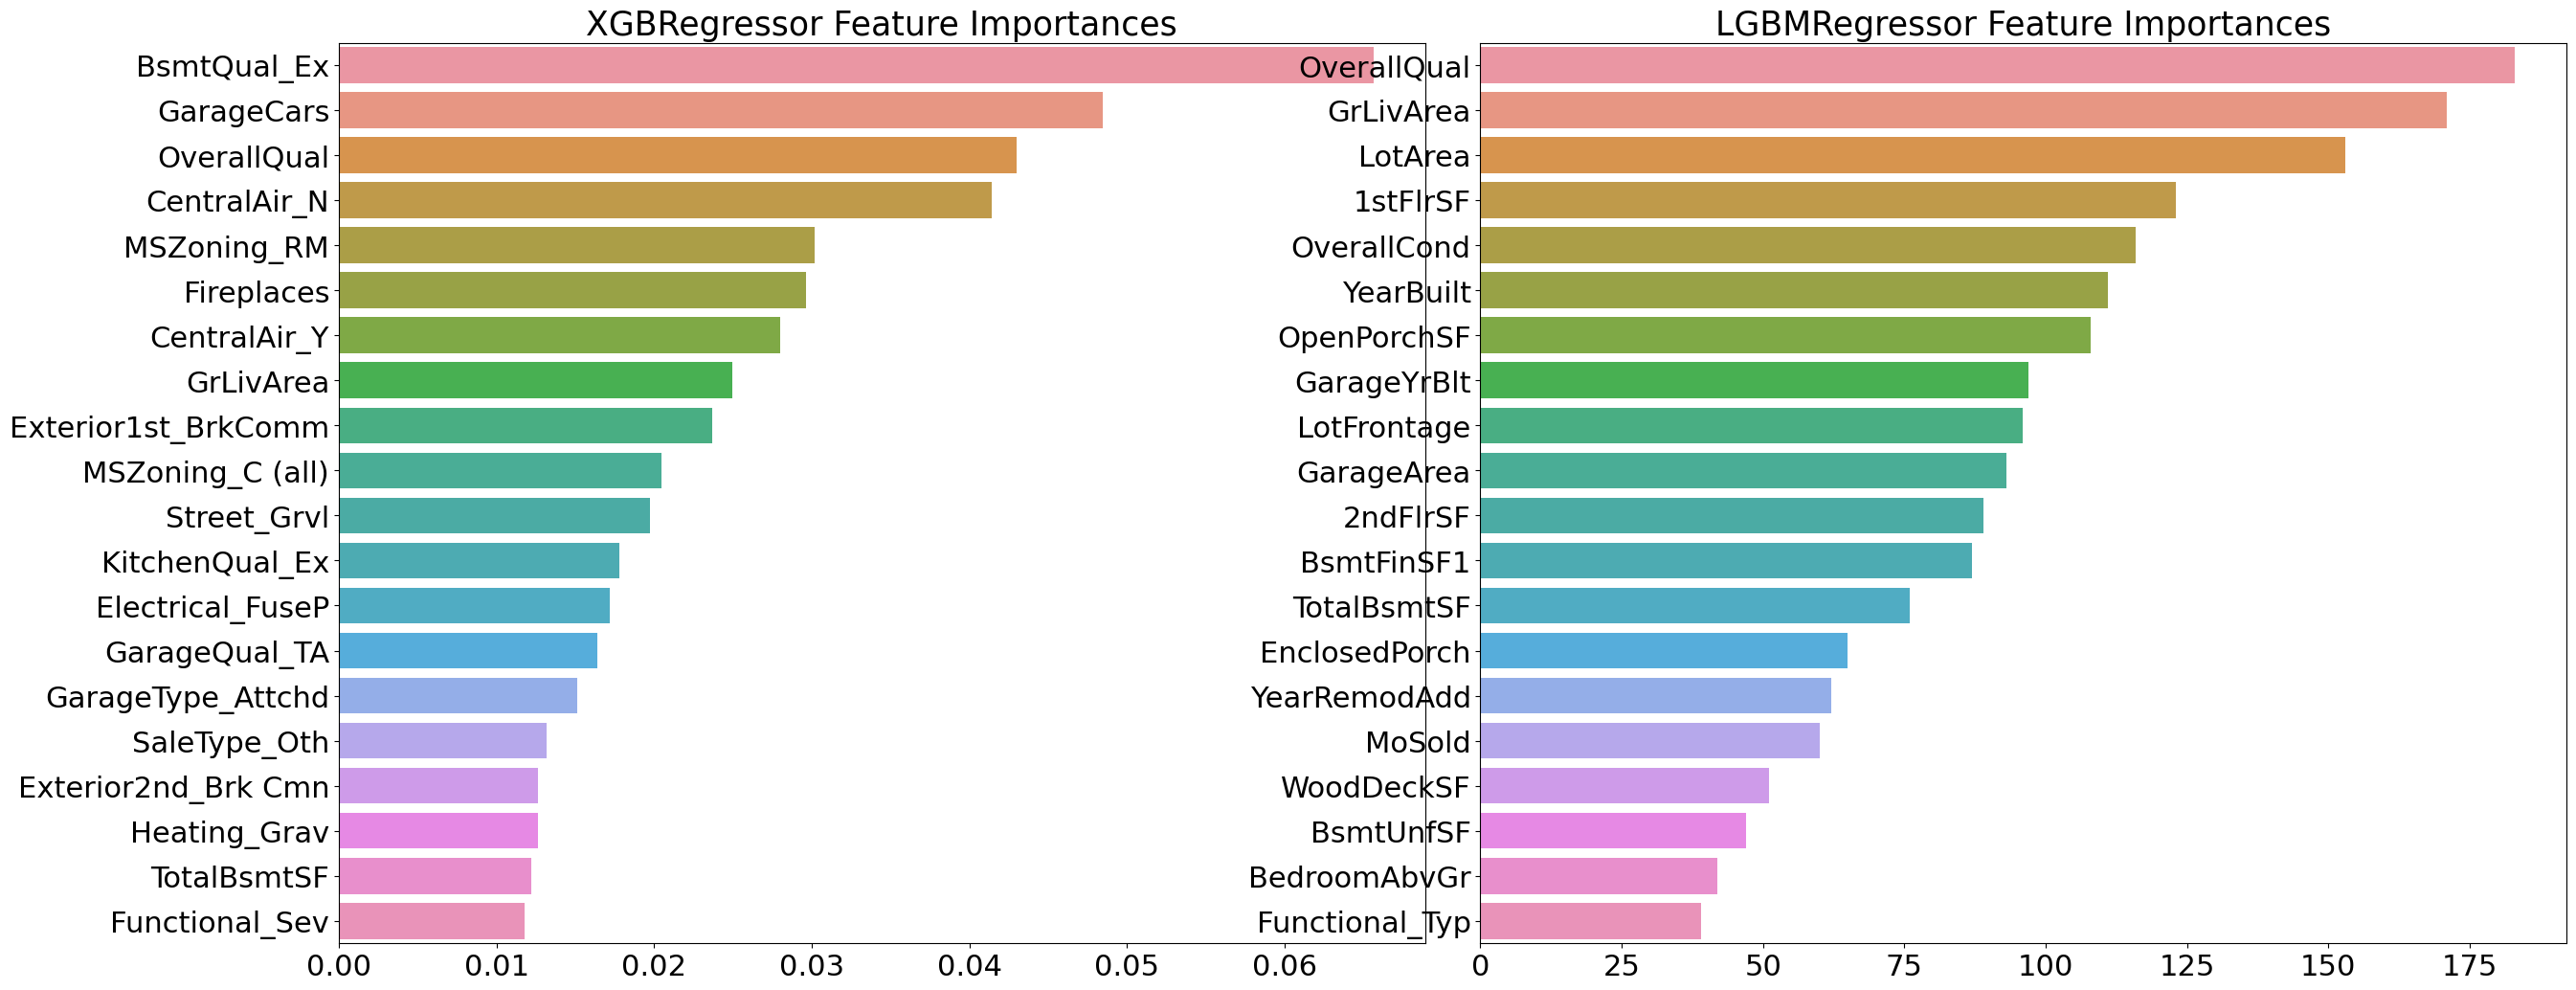

In [42]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

#### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [43]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key,rmse))
        
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합' :pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10212552213491137
Ridge 모델의 RMSE: 0.10822440025153762
Lasso 모델의 RMSE: 0.10092444580703608


In [45]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, reg_lambda = 10, n_jobs=-1,
                         colsample_bytree=0.5, subsample=0.8)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_reg = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_reg
preds = {'최종 혼합' :pred, 'XGBM': xgb_pred, 'LGBM': lgbm_reg}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10279073822818922
XGBM 모델의 RMSE: 0.10742752210653753
LGBM 모델의 RMSE: 0.10449838809107072
